In [1]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
from sklearn.externals import joblib
import xgboost as xgb
import json
import time

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
import pandas as pd
from pprint import pprint
import sys
#import matplotlib.pyplot as plt
from sklearn.utils import resample

#import shap

import multiprocessing
cpu_count = multiprocessing.cpu_count()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#path = "/Users/jay/MSC_WSBDA/MSc_Thesis/Msc_project/Data/"
path = '/Users/syamantak/JayateeB/new_files/data/'
event = 'nyc'
start_hour = 7


In [3]:
def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y



In [11]:
initial_features = load_pickle_file(path+event+'_'+str(start_hour)+'_hrs_data.pkl')
users = load_pickle_file(path+'nyc/'+event+"_users.dat")
users.reset_index(drop =True , inplace =True)

Loading data file from /Users/syamantak/JayateeB/new_files/data/nyc_7_hrs_data.pkl
Loaded 135912 entries
Loading data file from /Users/syamantak/JayateeB/new_files/data/nyc/nyc_users.dat
Loaded 135912 entries


In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [15]:
def prepare_data(initial_features):
    df = initial_features
    
    df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
    df = df.reset_index(drop=True)
    
    #df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)
    df = df.drop(columns = ['user_id', 'infected_status', 'infection_time'],axis = 1)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y

In [16]:
# 1. Prepare
df, X, y = prepare_data(initial_features)

[Original] data counts, with uninfected (0): 56676, infected (1): 79236


In [17]:
feature_columns = X.columns
print('There are {} Features'.format(len(feature_columns)))

There are 88 Features


In [18]:
def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

In [19]:
def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

In [20]:
def train(df, X, y, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = xgb.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = xgb.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = xgb.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = xgb.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        #auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst

In [21]:
#xgboost
param = {
    'max_depth':3,
    # Step size shrinkage used in update to prevents overfitting. 
    # After each boosting step, we can directly get the weights of new features, 
    # and eta shrinks the feature weights to make the boosting process more conservative.
    'eta': 0.1,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be.
    'gamma':10,
    # Minimum sum of instance weight (hessian) needed in a child. 
    # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
    # then the building process will give up further partitioning.
    # The larger min_child_weight is, the more conservative the algorithm will be.
    'min_child_weight':10,
    'silent': 1, # 0 means printing running messages, 1 means silent mode
    'objective': 'binary:logistic',
    'subsample': 0.9
}
param['nthread'] = cpu_count
param['eval_metric'] = ['auc']
num_boost_round = 1000
rebalance_method = 'up'

Start cross validation
===Processing fold 0===
1.0    28338
0.0    28338
Name: label, dtype: int64
[0]	train-auc:0.662134	eval-auc:0.660094
[1]	train-auc:0.677448	eval-auc:0.674699
[2]	train-auc:0.682446	eval-auc:0.680672
[3]	train-auc:0.684138	eval-auc:0.683272
[4]	train-auc:0.685936	eval-auc:0.685736
[5]	train-auc:0.687538	eval-auc:0.687623
[6]	train-auc:0.687604	eval-auc:0.687534
[7]	train-auc:0.692215	eval-auc:0.691647
[8]	train-auc:0.693613	eval-auc:0.693029
[9]	train-auc:0.696128	eval-auc:0.695659
[10]	train-auc:0.698426	eval-auc:0.697866
[11]	train-auc:0.698416	eval-auc:0.697818
[12]	train-auc:0.698826	eval-auc:0.698244
[13]	train-auc:0.701429	eval-auc:0.700767
[14]	train-auc:0.702824	eval-auc:0.701796
[15]	train-auc:0.704459	eval-auc:0.702987
[16]	train-auc:0.705642	eval-auc:0.704178
[17]	train-auc:0.70723	eval-auc:0.705282
[18]	train-auc:0.70822	eval-auc:0.706118
[19]	train-auc:0.709314	eval-auc:0.70694
[20]	train-auc:0.709984	eval-auc:0.707505
[21]	train-auc:0.710895	eval-auc

[192]	train-auc:0.75835	eval-auc:0.734759
[193]	train-auc:0.758514	eval-auc:0.734774
[194]	train-auc:0.758633	eval-auc:0.734772
[195]	train-auc:0.758792	eval-auc:0.73483
[196]	train-auc:0.758792	eval-auc:0.73483
[197]	train-auc:0.759	eval-auc:0.734819
[198]	train-auc:0.759	eval-auc:0.734819
[199]	train-auc:0.759058	eval-auc:0.734804
[200]	train-auc:0.759147	eval-auc:0.734838
[201]	train-auc:0.759327	eval-auc:0.734867
[202]	train-auc:0.759615	eval-auc:0.73492
[203]	train-auc:0.759765	eval-auc:0.734942
[204]	train-auc:0.759963	eval-auc:0.734988
[205]	train-auc:0.760268	eval-auc:0.735074
[206]	train-auc:0.76043	eval-auc:0.735087
[207]	train-auc:0.760537	eval-auc:0.735055
[208]	train-auc:0.760692	eval-auc:0.735037
[209]	train-auc:0.760893	eval-auc:0.735096
[210]	train-auc:0.760929	eval-auc:0.735087
[211]	train-auc:0.761131	eval-auc:0.735158
[212]	train-auc:0.761229	eval-auc:0.735164
[213]	train-auc:0.761355	eval-auc:0.735232
[214]	train-auc:0.761554	eval-auc:0.735267
[215]	train-auc:0.7616

[384]	train-auc:0.776617	eval-auc:0.737654
[385]	train-auc:0.776617	eval-auc:0.737654
[386]	train-auc:0.776618	eval-auc:0.737673
[387]	train-auc:0.776648	eval-auc:0.737669
[388]	train-auc:0.776751	eval-auc:0.737712
[389]	train-auc:0.776905	eval-auc:0.737687
[390]	train-auc:0.776905	eval-auc:0.737687
[391]	train-auc:0.776996	eval-auc:0.737748
[392]	train-auc:0.777108	eval-auc:0.737728
[393]	train-auc:0.777143	eval-auc:0.73773
[394]	train-auc:0.777196	eval-auc:0.737719
[395]	train-auc:0.777381	eval-auc:0.737746
[396]	train-auc:0.777381	eval-auc:0.737746
[397]	train-auc:0.777457	eval-auc:0.737688
[398]	train-auc:0.777457	eval-auc:0.737688
[399]	train-auc:0.777568	eval-auc:0.737676
[400]	train-auc:0.777648	eval-auc:0.737672
[401]	train-auc:0.777648	eval-auc:0.737672
[402]	train-auc:0.777647	eval-auc:0.737672
[403]	train-auc:0.777782	eval-auc:0.737671
[404]	train-auc:0.777857	eval-auc:0.737658
[405]	train-auc:0.777946	eval-auc:0.737653
[406]	train-auc:0.777946	eval-auc:0.737653
[407]	train-

[576]	train-auc:0.789149	eval-auc:0.738343
[577]	train-auc:0.789269	eval-auc:0.738369
[578]	train-auc:0.789334	eval-auc:0.738381
[579]	train-auc:0.789488	eval-auc:0.738388
[580]	train-auc:0.789524	eval-auc:0.738376
[581]	train-auc:0.789568	eval-auc:0.738393
[582]	train-auc:0.789572	eval-auc:0.738414
[583]	train-auc:0.789649	eval-auc:0.738422
[584]	train-auc:0.789649	eval-auc:0.738422
[585]	train-auc:0.789649	eval-auc:0.738422
[586]	train-auc:0.789649	eval-auc:0.738422
[587]	train-auc:0.789664	eval-auc:0.738446
[588]	train-auc:0.789675	eval-auc:0.738429
[589]	train-auc:0.789675	eval-auc:0.738429
[590]	train-auc:0.789758	eval-auc:0.738449
[591]	train-auc:0.789865	eval-auc:0.738439
[592]	train-auc:0.789865	eval-auc:0.738439
[593]	train-auc:0.789937	eval-auc:0.738464
[594]	train-auc:0.790034	eval-auc:0.738442
[595]	train-auc:0.790034	eval-auc:0.738442
[596]	train-auc:0.7902	eval-auc:0.738432
[597]	train-auc:0.7902	eval-auc:0.738432
[598]	train-auc:0.790278	eval-auc:0.738427
[599]	train-auc

[768]	train-auc:0.796944	eval-auc:0.739189
[769]	train-auc:0.797079	eval-auc:0.739155
[770]	train-auc:0.797131	eval-auc:0.739155
[771]	train-auc:0.797131	eval-auc:0.739155
[772]	train-auc:0.797131	eval-auc:0.739155
[773]	train-auc:0.797131	eval-auc:0.739155
[774]	train-auc:0.797131	eval-auc:0.739155
[775]	train-auc:0.797131	eval-auc:0.739155
[776]	train-auc:0.797208	eval-auc:0.73915
[777]	train-auc:0.797333	eval-auc:0.739122
[778]	train-auc:0.797333	eval-auc:0.739122
[779]	train-auc:0.797395	eval-auc:0.739148
[780]	train-auc:0.797435	eval-auc:0.739144
[781]	train-auc:0.797435	eval-auc:0.739144
[782]	train-auc:0.797435	eval-auc:0.739144
[783]	train-auc:0.79755	eval-auc:0.739124
[784]	train-auc:0.79755	eval-auc:0.739124
[785]	train-auc:0.797639	eval-auc:0.739133
[786]	train-auc:0.797639	eval-auc:0.739133
[787]	train-auc:0.797826	eval-auc:0.73911
[788]	train-auc:0.797826	eval-auc:0.73911
[789]	train-auc:0.797826	eval-auc:0.73911
[790]	train-auc:0.797826	eval-auc:0.73911
[791]	train-auc:0.

[960]	train-auc:0.803732	eval-auc:0.738979
[961]	train-auc:0.803805	eval-auc:0.738961
[962]	train-auc:0.803805	eval-auc:0.738961
[963]	train-auc:0.803876	eval-auc:0.738943
[964]	train-auc:0.803876	eval-auc:0.738943
[965]	train-auc:0.803902	eval-auc:0.738932
[966]	train-auc:0.803975	eval-auc:0.738907
[967]	train-auc:0.803975	eval-auc:0.738907
[968]	train-auc:0.804111	eval-auc:0.738922
[969]	train-auc:0.804111	eval-auc:0.738922
[970]	train-auc:0.804178	eval-auc:0.738928
[971]	train-auc:0.804178	eval-auc:0.738928
[972]	train-auc:0.804282	eval-auc:0.738916
[973]	train-auc:0.804357	eval-auc:0.738894
[974]	train-auc:0.80438	eval-auc:0.738879
[975]	train-auc:0.804386	eval-auc:0.738876
[976]	train-auc:0.804421	eval-auc:0.738886
[977]	train-auc:0.804458	eval-auc:0.738879
[978]	train-auc:0.804458	eval-auc:0.738879
[979]	train-auc:0.804539	eval-auc:0.738864
[980]	train-auc:0.804661	eval-auc:0.738873
[981]	train-auc:0.804709	eval-auc:0.738877
[982]	train-auc:0.804709	eval-auc:0.738877
[983]	train-

/Users/syamantak/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/syamantak/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


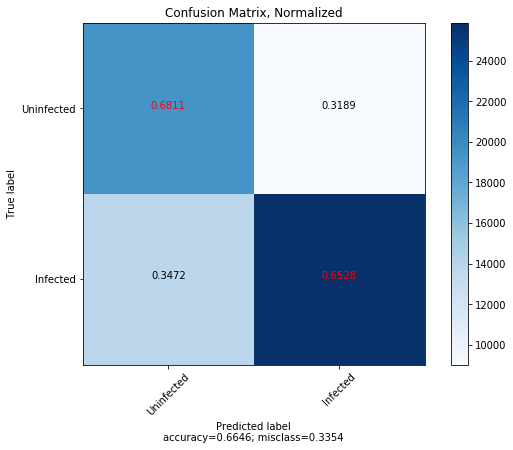

===Processing fold 1===
1.0    28338
0.0    28338
Name: label, dtype: int64
[0]	train-auc:0.663099	eval-auc:0.659159
[1]	train-auc:0.674307	eval-auc:0.669424
[2]	train-auc:0.679268	eval-auc:0.673742
[3]	train-auc:0.680974	eval-auc:0.675379
[4]	train-auc:0.684678	eval-auc:0.679274
[5]	train-auc:0.691197	eval-auc:0.685368
[6]	train-auc:0.692652	eval-auc:0.686714
[7]	train-auc:0.696095	eval-auc:0.689903
[8]	train-auc:0.697454	eval-auc:0.69139
[9]	train-auc:0.698172	eval-auc:0.69212
[10]	train-auc:0.700192	eval-auc:0.693995
[11]	train-auc:0.700962	eval-auc:0.695226
[12]	train-auc:0.702949	eval-auc:0.696812
[13]	train-auc:0.703281	eval-auc:0.696943
[14]	train-auc:0.704864	eval-auc:0.698442
[15]	train-auc:0.705259	eval-auc:0.698888
[16]	train-auc:0.705909	eval-auc:0.699183
[17]	train-auc:0.706834	eval-auc:0.699654
[18]	train-auc:0.708124	eval-auc:0.701135
[19]	train-auc:0.709619	eval-auc:0.702643
[20]	train-auc:0.710882	eval-auc:0.703533
[21]	train-auc:0.711559	eval-auc:0.703991
[22]	train-a

[193]	train-auc:0.761405	eval-auc:0.733753
[194]	train-auc:0.761618	eval-auc:0.733777
[195]	train-auc:0.761728	eval-auc:0.733776
[196]	train-auc:0.761766	eval-auc:0.733789
[197]	train-auc:0.761766	eval-auc:0.733789
[198]	train-auc:0.761898	eval-auc:0.733809
[199]	train-auc:0.762041	eval-auc:0.733793
[200]	train-auc:0.762188	eval-auc:0.733833
[201]	train-auc:0.762295	eval-auc:0.733839
[202]	train-auc:0.762424	eval-auc:0.733911
[203]	train-auc:0.762563	eval-auc:0.733948
[204]	train-auc:0.762563	eval-auc:0.733948
[205]	train-auc:0.762703	eval-auc:0.733969
[206]	train-auc:0.762915	eval-auc:0.734019
[207]	train-auc:0.763075	eval-auc:0.734003
[208]	train-auc:0.763192	eval-auc:0.734022
[209]	train-auc:0.763261	eval-auc:0.734049
[210]	train-auc:0.763433	eval-auc:0.734132
[211]	train-auc:0.763498	eval-auc:0.734099
[212]	train-auc:0.763691	eval-auc:0.734168
[213]	train-auc:0.763691	eval-auc:0.734168
[214]	train-auc:0.763829	eval-auc:0.734144
[215]	train-auc:0.763935	eval-auc:0.734158
[216]	train

[385]	train-auc:0.778502	eval-auc:0.736823
[386]	train-auc:0.778538	eval-auc:0.736817
[387]	train-auc:0.778633	eval-auc:0.736759
[388]	train-auc:0.778722	eval-auc:0.73678
[389]	train-auc:0.778722	eval-auc:0.73678
[390]	train-auc:0.778722	eval-auc:0.73678
[391]	train-auc:0.778784	eval-auc:0.736766
[392]	train-auc:0.778862	eval-auc:0.73679
[393]	train-auc:0.779023	eval-auc:0.736759
[394]	train-auc:0.779045	eval-auc:0.736754
[395]	train-auc:0.779178	eval-auc:0.736789
[396]	train-auc:0.779334	eval-auc:0.736789
[397]	train-auc:0.779397	eval-auc:0.736797
[398]	train-auc:0.779442	eval-auc:0.736781
[399]	train-auc:0.779507	eval-auc:0.736812
[400]	train-auc:0.779539	eval-auc:0.736803
[401]	train-auc:0.779597	eval-auc:0.736784
[402]	train-auc:0.779637	eval-auc:0.73678
[403]	train-auc:0.779769	eval-auc:0.73681
[404]	train-auc:0.779798	eval-auc:0.736813
[405]	train-auc:0.779902	eval-auc:0.736803
[406]	train-auc:0.780067	eval-auc:0.736816
[407]	train-auc:0.780139	eval-auc:0.736849
[408]	train-auc:0

[577]	train-auc:0.790035	eval-auc:0.737729
[578]	train-auc:0.790112	eval-auc:0.737756
[579]	train-auc:0.790199	eval-auc:0.737784
[580]	train-auc:0.790199	eval-auc:0.737784
[581]	train-auc:0.790235	eval-auc:0.737812
[582]	train-auc:0.790277	eval-auc:0.73784
[583]	train-auc:0.790277	eval-auc:0.73784
[584]	train-auc:0.790315	eval-auc:0.737823
[585]	train-auc:0.790425	eval-auc:0.737868
[586]	train-auc:0.79048	eval-auc:0.737859
[587]	train-auc:0.790585	eval-auc:0.737859
[588]	train-auc:0.790585	eval-auc:0.737859
[589]	train-auc:0.790626	eval-auc:0.737851
[590]	train-auc:0.790771	eval-auc:0.737924
[591]	train-auc:0.790828	eval-auc:0.737901
[592]	train-auc:0.790847	eval-auc:0.73789
[593]	train-auc:0.790942	eval-auc:0.73792
[594]	train-auc:0.790967	eval-auc:0.737914
[595]	train-auc:0.791048	eval-auc:0.737926
[596]	train-auc:0.791048	eval-auc:0.737926
[597]	train-auc:0.791048	eval-auc:0.737926
[598]	train-auc:0.791131	eval-auc:0.737905
[599]	train-auc:0.791131	eval-auc:0.737905
[600]	train-auc:

[769]	train-auc:0.798562	eval-auc:0.738376
[770]	train-auc:0.798612	eval-auc:0.738346
[771]	train-auc:0.798673	eval-auc:0.738334
[772]	train-auc:0.79879	eval-auc:0.738317
[773]	train-auc:0.798844	eval-auc:0.738315
[774]	train-auc:0.798897	eval-auc:0.738297
[775]	train-auc:0.798897	eval-auc:0.738297
[776]	train-auc:0.799045	eval-auc:0.738283
[777]	train-auc:0.799067	eval-auc:0.738271
[778]	train-auc:0.799111	eval-auc:0.738259
[779]	train-auc:0.799111	eval-auc:0.738259
[780]	train-auc:0.799219	eval-auc:0.738264
[781]	train-auc:0.799219	eval-auc:0.738264
[782]	train-auc:0.799241	eval-auc:0.738269
[783]	train-auc:0.799261	eval-auc:0.738261
[784]	train-auc:0.799261	eval-auc:0.738261
[785]	train-auc:0.799379	eval-auc:0.738269
[786]	train-auc:0.799379	eval-auc:0.738269
[787]	train-auc:0.799379	eval-auc:0.738269
[788]	train-auc:0.799379	eval-auc:0.738269
[789]	train-auc:0.799523	eval-auc:0.738262
[790]	train-auc:0.799523	eval-auc:0.738262
[791]	train-auc:0.799523	eval-auc:0.738262
[792]	train-

[961]	train-auc:0.804923	eval-auc:0.738627
[962]	train-auc:0.804923	eval-auc:0.738627
[963]	train-auc:0.805017	eval-auc:0.738609
[964]	train-auc:0.805017	eval-auc:0.738609
[965]	train-auc:0.805072	eval-auc:0.738621
[966]	train-auc:0.805123	eval-auc:0.73865
[967]	train-auc:0.805164	eval-auc:0.738662
[968]	train-auc:0.805208	eval-auc:0.738646
[969]	train-auc:0.805211	eval-auc:0.73866
[970]	train-auc:0.805245	eval-auc:0.738652
[971]	train-auc:0.805293	eval-auc:0.738628
[972]	train-auc:0.805379	eval-auc:0.738597
[973]	train-auc:0.805379	eval-auc:0.738597
[974]	train-auc:0.805379	eval-auc:0.738597
[975]	train-auc:0.805379	eval-auc:0.738597
[976]	train-auc:0.805379	eval-auc:0.738597
[977]	train-auc:0.805379	eval-auc:0.738597
[978]	train-auc:0.805396	eval-auc:0.738564
[979]	train-auc:0.805396	eval-auc:0.738564
[980]	train-auc:0.805396	eval-auc:0.738564
[981]	train-auc:0.805461	eval-auc:0.738549
[982]	train-auc:0.805484	eval-auc:0.738551
[983]	train-auc:0.805586	eval-auc:0.738581
[984]	train-a

/Users/syamantak/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/syamantak/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


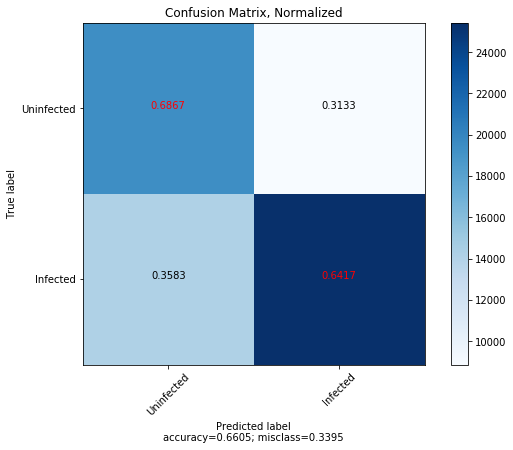

Finished cross validation
MSE: 0    0.205321
dtype: float64 
ACC: 0    0.662546
dtype: float64 
AUC: 0    0.738728
dtype: float64 
ACC for t at 210: 0   NaN
dtype: float64 
Empty DataFrame
Columns: [average corr]
Index: []


In [22]:
xgb_model = train(df, X, y, param, 2, num_boost_round, rebalance_method)

In [23]:
columns = list(df.columns)
columns.remove('label')
if rebalance_method == 'up':
    df_rebalance = upsample(df)
if rebalance_method == 'down':
    df_rebalance = downsample(df)
X = df_rebalance[columns]
y = df_rebalance[['label']]

# load JS visualization code to notebook
#shap.initjs()

# train XGBoost model

model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

1.0    56676
0.0    56676
Name: label, dtype: int64


In [24]:
with open(path+event+'_xgb_model_'+str(start_hour)+'_hrs.dat', 'wb') as file:
    pickle.dump(model, file)